In [ ]:
!pip install svetlanna
!pip install reservoirpy matplotlib tqdm requests av scikit-image py-cpuinfo gputil pandas

### Imports

In [1]:
import os
import sys
import random

In [2]:
import time
import json

In [3]:
# import warnings
# warnings.simplefilter("always")  # всегде отображай уведомления

In [4]:
import numpy as np

In [5]:
from collections import Counter

In [6]:
import torch
from torch.utils.data import Dataset

In [7]:
from torch import nn

In [8]:
from torch.nn import functional

In [9]:
import torchvision
import torchvision.transforms as transforms

In [10]:
from torchvision.transforms import InterpolationMode

In [11]:
# our library
from svetlanna import SimulationParameters
from svetlanna.parameters import ConstrainedParameter

In [12]:
# our library
from svetlanna import Wavefront
from svetlanna import elements
from svetlanna.detector import Detector, DetectorProcessorClf

In [13]:
from svetlanna.transforms import ToWavefront

In [14]:
# dataset
from src.wf_datasets import DatasetOfWavefronts

In [15]:
from tqdm import tqdm

In [16]:
from datetime import datetime

In [17]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from mpl_toolkits.axes_grid1 import make_axes_locatable

plt.style.use('dark_background')
%matplotlib inline
# %config InlineBackend.figure_format = 'retina'

# Сверточная диффракционная нейронная сеть 

Данный пример основан на результатах статьи: <span style="color:orange">"Optical Diffractive Convolutional Neural Networks
Implemented in an All-Optical Way"</span> [[1]](https://www.mdpi.com/1424-8220/23/12/5749).


In [18]:
today_date = datetime.today().strftime('%d-%m-%Y_%H-%M')  # Дата для создания дериктории с результатами моделирования
today_date

'28-07-2025_20-32'

In [ ]:
#  Определение необходимых переменных для моделирования
#
VARIABLES = {
    # ПУТИ К ФАЙЛАМ
    'data_path': './data',  # папка, которая будет создана (если не существует) для загрузки/сохранения датасета Weizmann
    'results_path': f'models/convolutional/conv_exp_{today_date}',  # путь для сохранения результатов!

    # ОБЩИЕ НАСТРОЙКИ - РАЗДЕЛ 1 блокнота
    'wavelength': 750 * 1e-6,  # рабочая длина волны, в метрах [м]
    'neuron_size': 0.5 * 750 * 1e-6,  # размер пикселя для DiffractiveLayers, в метрах [м]
    'mesh_size': (200, 200),  # полный размер слоя = численная сетка
        # Комментарий: значение из статьи [1] - (200, 200)

    'use_apertures': False,  # нужно ли добавлять апертуры перед каждым дифракционным слоем
        # Комментарий: значение из статьи [1] - неизвестно
    'aperture_size': (64, 64),  # размер каждой апертуры = квадрат детектора для зон классов
        # Комментарий: значение из статьи [1] - неизвестно

    # НАСТРОЙКИ ДАТАСЕТА ПОДПОСЛЕДОВАТЕЛЬНОСТЕЙ - РАЗДЕЛ 2 блокнота
    'resize': (28, 28),  # размер, до которого масштабируются изображения, затем добавляется нулевое заполнение (до размера сетки)
        # Комментарий: значение из статьи - входное изображение размером 28 * 28 пикселей
    'modulation': 'amp',  # тип модуляции для формирования волнового фронта из каждой маски изображения (см. 2.3.2.)
        # Комментарий: может быть равен `phase`, `amp` или `both`

    # НЕЙРОСЕТЬ - РАЗДЕЛ 3 блокнота
    'max_phase': 2 * torch.pi,  # максимальная возможная фаза для каждого DiffractiveLayer
    'free_space_method': 'AS',  # метод распространения
        # Комментарий: может быть 'AS' или 'fresnel'
    'distance': 3 * 1e-2,  # расстояние между дифракционными слоями

    # 4F-СИСТЕМА
    'focal_length': 3 * 1e-2,  # в метрах [м]
    'lens_radius': torch.inf,
        # Комментарий: если радиус линзы равен torch.inf — аналитическая линза!
    'learnable_kernel': False,

    # ДИФРАКЦИОННЫЕ СЛОИ
    'use_slm': False,  # использовать ли SLM (если True) или DiffractiveLayers (если False)
    'num_layers': 5,
    'init_phases': torch.pi,
    # значение или список начальных постоянных фаз для DiffractiveLayers или SLM
    # настройки SLM — если 'use_slm' == True
        # Комментарий: размер каждого SLM соответствует SimulationParameters!
    'slm_shapes': [(200, 200), (200, 200), (100, 100), (100, 100), (100, 100)],
        # список размеров, длина которого равна числу слоев энкодера
    'slm_levels': 256,
        # значение или список (длина = 'encoder_num_layers') количества уровней для каждого SLM
    'slm_step_funcs': 'linear',  # значение или список названий ступенчатых функций
        # Комментарий: доступные названия ступенчатых функций — 'linear'

    # ОБУЧЕНИЕ СЕТИ - РАЗДЕЛ 4 блокнота
    'calculate_accuracies': True,  # всегда будет True для CrossEntropyLoss! (см. 3.1.4.)
        # Комментарий: используется MSE loss!
    'DEVICE': 'cpu',  # если `cuda` — будет проверка, доступна ли она (см. первые ячейки в разделе 4)
    'train_batch_size': 64,  # размер пакета для обучения (см. 4.1.1.)
    'val_batch_size': 64,
        # Комментарий: значение из статьи [1] — 64  # для обучения и теста?
    'adam_lr': 0.01,  # скорость обучения для оптимизатора Adam (см. 4.1.2.)
        # Комментарий: значение из статьи [1] — 0.01
    'number_of_epochs': 20,  # количество эпох обучения
        # Комментарий: значение из статьи [1] — 100-300?!
}


In [20]:
# Функция для шага SLM(cмотри документацию для SLM)
SLM_STEPS = {
    'linear': lambda x: x,
}

In [21]:
RESULTS_FOLDER = VARIABLES['results_path']

#Создание директории для сохранения результатов
if not os.path.exists(RESULTS_FOLDER):
    os.makedirs(RESULTS_FOLDER)

In [22]:
RESULTS_FOLDER

'models/convolutional/conv_exp_28-07-2025_20-32'

In [23]:
#Сохранение условий численного эксперимента( в директорию VARIABLES)
with open(f'{RESULTS_FOLDER}/conditions.json', 'w', encoding ='utf8') as json_file:
    json.dump(VARIABLES, json_file, ensure_ascii = True)

# 1. Параметры моделирования

Так как статья [[1]](https://www.mdpi.com/1424-8220/23/12/5749) не содержит ключевых параметров необходимых для моделирования, мы выбрали параметры из другой работы [[2]](https://ieeexplore.ieee.org/abstract/document/8732486), которые использовали в других примерах.

In [24]:
working_wavelength = VARIABLES['wavelength']

c_const = 299_792_458  # [м / с]
working_frequency = c_const / working_wavelength # [Гц]

In [25]:
print(f'lambda    = {working_wavelength * 1e3:.3f} mm')
print(f'frequency = {working_frequency / 1e12:.3f} THz')

lambda    = 0.750 mm
frequency = 0.400 THz


In [ ]:
# neuron size (square)
neuron_size = VARIABLES['neuron_size']
print(f'neuron size = {neuron_size * 1e3:.3f} mm')

neuron size = 0.375 mm


In [27]:
APERTURES = VARIABLES['use_apertures']  # флаг добавления апертур перед каждым дифракционным элементом.

In [28]:
LAYER_SIZE = VARIABLES['mesh_size']  # размер расчетной сетки
DETECTOR_SIZE = VARIABLES['aperture_size']

In [29]:
# количество нейронов в моделировании
x_layer_nodes = LAYER_SIZE[1]
y_layer_nodes = LAYER_SIZE[0]

print(f'Layer size (in neurons): {x_layer_nodes} x {y_layer_nodes} = {x_layer_nodes * y_layer_nodes}')

Layer size (in neurons): 200 x 200 = 40000


In [30]:
# физический размер каждого слоя
x_layer_size_m = x_layer_nodes * neuron_size  # [m]
y_layer_size_m = y_layer_nodes * neuron_size

print(f'Layer size (in mm): {x_layer_size_m * 1e3 :.3f} x {y_layer_size_m * 1e3 :.3f}')

Layer size (in mm): 75.000 x 75.000


In [31]:
X_LAYER_SIZE_M = x_layer_size_m
Y_LAYER_SIZE_M = y_layer_size_m

In [32]:
# Параметры симуляции

SIM_PARAMS = SimulationParameters(
    axes={
        'W': torch.linspace(-x_layer_size_m / 2, x_layer_size_m / 2, x_layer_nodes),
        'H': torch.linspace(-y_layer_size_m / 2, y_layer_size_m / 2, y_layer_nodes),
        'wavelength': working_wavelength,  # only one wavelength!
    }
)

# 2. Подготовка Датасета

## 2.1. [MNIST датасет](https://www.kaggle.com/datasets/hojjatk/mnist-dataset)

In [ ]:
# инициализация директории датасета
# MNIST_DATA_FOLDER = VARIABLES['data_path']

NUM_CLASSES = 10

### 2.1.1. Загрузка датасетов изображений для обучения и тестирования 

In [34]:
# Обучение (изображения)
mnist_train_ds = torchvision.datasets.MNIST(
    root= MNIST_DATA_FOLDER,
    train=True,  # для загрузки обучающей выборки
    download=True,
)

100%|██████████| 9.91M/9.91M [00:02<00:00, 4.78MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 199kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 2.45MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 103kB/s]


In [35]:
# Тест (изображения)
mnist_test_ds = torchvision.datasets.MNIST(
    root=MNIST_DATA_FOLDER,
    train=False,  # для загрузки выборки для тестирования
    download=True,
)

In [36]:
print(f'Train data: {len(mnist_train_ds)}')
print(f'Test data : {len(mnist_test_ds)}')

Train data: 60000
Test data : 10000


### 2.1.2. Создание датасетов волновых фронтов для обучения и теста

> Входные изображения размером $28 \times 28$ пикселей были увеличины до $200 \times 200$ нулевым заполнением 

In [37]:
# Выбор типа модуляции
MODULATION_TYPE = VARIABLES['modulation']  # используется ТОЛЬКО амплитуда для кодирования каждого изображения в виде волнового фронта
RESIZE_SHAPE = VARIABLES['resize']  # размер, до которого масштабируются изображения перед добавлением нулевого заполнения (до размера сетки)

#### Преобразования

In [38]:
resize_y = RESIZE_SHAPE[0]
resize_x = RESIZE_SHAPE[1]  # размер для функции transforms.Resize

# заполнение по оси OY
pad_top = int((y_layer_nodes - resize_y) / 2)
pad_bottom = y_layer_nodes - pad_top - resize_y
# заполнение по оси OX
pad_left = int((x_layer_nodes - resize_x) / 2)
pad_right = x_layer_nodes - pad_left - resize_x  # параметры для функции transforms.Pad

In [ ]:
# объединение всех преобразований
image_transform_for_ds = transforms.Compose(
  [
      transforms.ToTensor(),
      transforms.Resize(
          size=(resize_y, resize_x),
          interpolation=InterpolationMode.NEAREST,
      ),
      transforms.Pad(
          padding=(
              pad_left,  # заполнение левой границы
              pad_top,  # заполнение верхней границы
              pad_right,  # заполнение правой границы
              pad_bottom  # заполнение нижней границы
          ),
          fill=0,
      ),
      ToWavefront(modulation_type=MODULATION_TYPE)  # <- выбор типа модуляции!!!
  ]
)

#### Detector mask

In [40]:
import src.detector_segmentation as detector_segmentation

In [41]:
number_of_classes = NUM_CLASSES

In [42]:
detector_segment_size = 6.4 * working_wavelength

In [43]:
# размер сегмента каждого нейрона
x_segment_nodes = int(detector_segment_size / neuron_size)
y_segment_nodes = int(detector_segment_size / neuron_size)
# each segment of size = (y_segment_nodes, x_segment_nodes)

In [44]:
y_boundary_nodes = y_segment_nodes * 12
x_boundary_nodes = x_segment_nodes * 12

In [45]:
DETECTOR_MASK = detector_segmentation.squares_mnist(
    y_boundary_nodes, x_boundary_nodes,  # размер детектора или апертуры (в центре детектора)
    SIM_PARAMS
)

Визуализация зон детектора 

In [46]:
ZONES_HIGHLIGHT_COLOR = 'r'
ZONES_LW = 0.5
selected_detector_mask = DETECTOR_MASK.clone().detach()

In [ ]:
def get_zones_patches(detector_mask):
    """
   Возвращает список областей для отображения зон детекторов для финальной визуализации.
    """
    zones_patches = []

    delta = 1 #0.5

    for ind_class in range(number_of_classes):
        idx_y, idx_x = (detector_mask == ind_class).nonzero(as_tuple=True)

        zone_rect = patches.Rectangle(
            (idx_x[0] - delta, idx_y[0] - delta),
            idx_x[-1] - idx_x[0] + 2 * delta, idx_y[-1] - idx_y[0] + 2 * delta,
            linewidth=ZONES_LW,
            edgecolor=ZONES_HIGHLIGHT_COLOR,
            facecolor='none'
        )

        zones_patches.append(zone_rect)

    return zones_patches

Визуализация маски

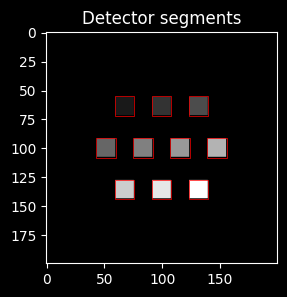

In [48]:
fig, ax0 = plt.subplots(1, 1, figsize=(3, 3))

ax0.set_title(f'Detector segments')
ax0.imshow(selected_detector_mask, cmap='grey')

for zone in get_zones_patches(selected_detector_mask):
    # add zone's patches to the axis
    # zone_copy = copy(zone)
    ax0.add_patch(zone)

plt.show()

#### Создание обучающий и тестирующей выборок датасета

In [49]:
# TRAIN dataset of WAVEFRONTS
mnist_wf_train_ds = DatasetOfWavefronts(
    init_ds=mnist_train_ds,  # Датасет изображений
    transformations=image_transform_for_ds,  # преобразования изображений
    sim_params=SIM_PARAMS,  # параметры моделирования
    target='detector',
    detector_mask=DETECTOR_MASK
)

In [50]:
# TEST dataset of WAVEFRONTS
mnist_wf_test_ds = DatasetOfWavefronts(
    init_ds=mnist_test_ds,  # датасет изображений
    transformations=image_transform_for_ds,  #  преобразования изображений
    sim_params=SIM_PARAMS,  # параметры моделирования
    target='detector',
    detector_mask=DETECTOR_MASK
)

In [51]:
print(f'Train data: {len(mnist_train_ds)}')
print(f'Test data : {len(mnist_test_ds)}')

Train data: 60000
Test data : 10000


#### Примеры

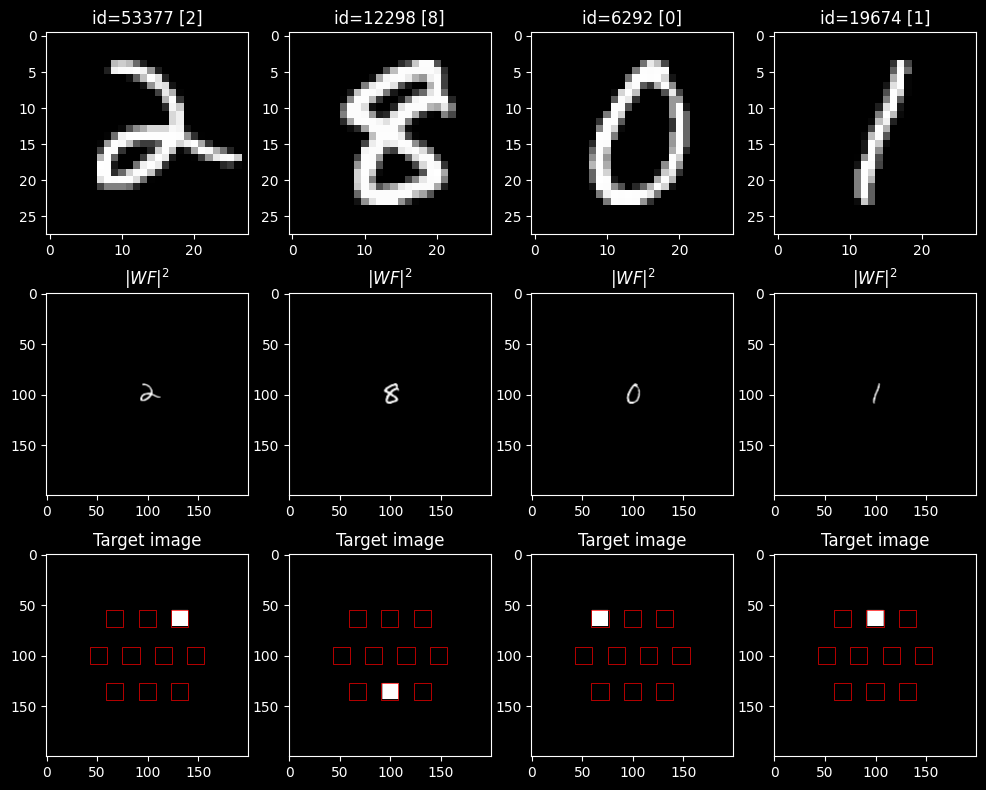

In [ ]:
# Отрисовка нескольких примеров из обучающей выборки
n_examples= 4

random.seed(78)
train_examples_ids = random.sample(range(len(mnist_train_ds)), n_examples)

all_examples_wavefronts = []

n_lines = 3
fig, axs = plt.subplots(n_lines, n_examples, figsize=(n_examples * 3, n_lines * 3.2))
for ind_ex, ind_train in enumerate(train_examples_ids):
    image, label = mnist_train_ds[ind_train]

    axs[0][ind_ex].set_title(f'id={ind_train} [{label}]')
    axs[0][ind_ex].imshow(image, cmap='gray')

    wavefront, target_image = mnist_wf_train_ds[ind_train]
    assert isinstance(wavefront, Wavefront)

    all_examples_wavefronts.append(wavefront)

    axs[1][ind_ex].set_title(f'$|WF|^2$')
    axs[1][ind_ex].imshow(
        wavefront.intensity, cmap='gray',
        vmin=0, vmax=1
    )

    axs[2][ind_ex].set_title(f'Target image')
    axs[2][ind_ex].imshow(
        target_image, cmap='gray',
        vmin=0, vmax= 1
    )

    for zone in get_zones_patches(selected_detector_mask):

        axs[2][ind_ex].add_patch(zone)

plt.show()

# 3. Дифракционная нейронная сеть со сверточным слоем 

In [53]:
FS_METHOD = VARIABLES['free_space_method']
FS_DISTANCE = VARIABLES['distance']  # [m] - расстояние между дифракционными слоями

MAX_PHASE = VARIABLES['max_phase']

## 3.1. Оптический сверточный слой

Смотри Figure 2 в [[1]](https://www.mdpi.com/1424-8220/23/12/5749)!

In [54]:
FOCAL_LENGTH = VARIABLES['focal_length']
LENS_R = VARIABLES['lens_radius']

LEARN_CONV = VARIABLES['learnable_kernel']

### 3.1.1. Функция прохождения 4f - системы

In [55]:
def get_free_space(
    freespace_sim_params,
    freespace_distance,  # in [m]!
    freespace_method='AS',
):
    """
    Возвращает слой FreeSpace с ограниченным параметром расстояния.
    """
    return elements.FreeSpace(
        simulation_parameters=freespace_sim_params,
        distance=freespace_distance,  # distance is not learnable!
        method=freespace_method
    )

In [ ]:
def get_4f_convolutional_layer(
    sim_params,
    focal_length,  # в [м]
    lens_radius,  # в [м]
    convolutional_mask,  # маска в диапазоне от 0 до max_phase
    learnable_mask = False,  # флаг обучаемости сверточной маски
    max_phase=2 * torch.pi,
    freespace_method='AS',
):
    """
    Возвращает список элементов для системы 4f с дифракционным слоем в Фурье-плоскости.
    """
    if learnable_mask:
        diff_layer = elements.DiffractiveLayer(
            simulation_parameters=sim_params,
            mask=ConstrainedParameter(
                convolutional_mask,
                min_value=0,
                max_value=max_phase
            ),  # ЗДЕСЬ МЫ ИСПОЛЬЗУЕМ ОГРАНИЧЕННЫЙ ПАРАМЕТР!
        )
    else:
        diff_layer = elements.DiffractiveLayer(
            simulation_parameters=sim_params,
            mask=convolutional_mask,
        )

    return [
        get_free_space(
            sim_params, focal_length, freespace_method
        ),
        elements.ThinLens(sim_params, focal_length, lens_radius),
        get_free_space(
            sim_params, focal_length, freespace_method
        ),
        diff_layer,  #
        get_free_space(
            sim_params, focal_length, freespace_method
        ),
        elements.ThinLens(sim_params, focal_length, lens_radius),
        get_free_space(
            sim_params, focal_length, freespace_method
        ),
    ]

### 3.1.2. Создание маски для объекта `DiffractiveLayer` помещенного в Фурьe-плоскость

Цитаты из [[1]](https://www.mdpi.com/1424-8220/23/12/5749)

> В сверточном слое 16 сверточных ядер были дискретизированы в виде массива $4 \times 4$ и размещены плиткой в плоском пространстве размером $200 \times 200$, как показано на Figure 6.

#### Функция для генерации ядра

In [57]:
from kernels.kernels import *

In [58]:
# Generate All 16 Kernels

def generate_16_kernels(size=9):
    k3 = predefined_3x3_kernels()

    kernels = [
        gaussian_kernel(size, sigma=1.0),
        gaussian_kernel(size, sigma=2.0),
        laplacian_of_gaussian(size, sigma=1.0),
        gabor_kernel(size, theta=0),
        gabor_kernel(size, theta=math.pi / 4),
        gabor_kernel(size, theta=math.pi / 2),
        gabor_kernel(size, theta=3 * math.pi / 4),
        upscale_kernel(k3['sobel_x'], size),
        upscale_kernel(k3['sobel_y'], size),
        upscale_kernel(k3['prewitt_x'], size),
        upscale_kernel(k3['prewitt_y'], size),
        upscale_kernel(k3['emboss'], size),
        identity_kernel(size),
        center_surround_edge_kernel(size),
        gabor_kernel(size, theta=math.pi / 8),
        gabor_kernel(size, theta=5 * math.pi / 8)
    ]

    return torch.stack(kernels)  # shape: (16, 9, 9)

In [ ]:
# Случайным образом перемешать ядра перед размещением
def embed_equally_spaced_kernels(canvas_size=200, grid_size=4, kernel_size=9):

    spacing = (canvas_size - (grid_size * kernel_size)) // (grid_size + 1)  # == 32
    kernels = generate_16_kernels()  # (16, 9, 9)
    canvas = torch.zeros((canvas_size, canvas_size))

    idx = 0
    for i in range(grid_size):
        for j in range(grid_size):
            y = spacing + i * (kernel_size + spacing)
            x = spacing + j * (kernel_size + spacing)
            canvas[y:y + kernel_size, x:x + kernel_size] = kernels[idx]
            idx += 1

    return canvas

#### Сверточный слой с сгенерированными ядрами.

In [60]:
KERNELS_MASK = embed_equally_spaced_kernels() * MAX_PHASE

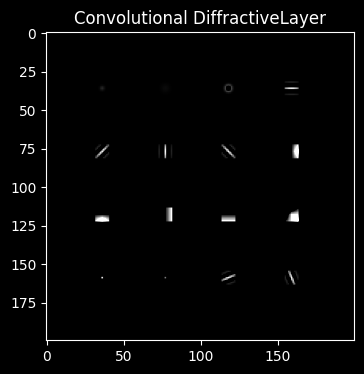

In [61]:
fig, ax0 = plt.subplots(1, 1, figsize=(4, 4))

ax0.set_title(f'Convolutional DiffractiveLayer')
ax0.imshow(KERNELS_MASK, cmap='grey', vmin=0, vmax=MAX_PHASE)

plt.show()

### 3.1.3. Сверточный слой (4f система)

In [ ]:
CONV_LAYER = get_4f_convolutional_layer(
    SIM_PARAMS,
    FOCAL_LENGTH,  # in [m]
    LENS_R,  # in [m]
    KERNELS_MASK,  # mask from 0 to max_phase
    learnable_mask=LEARN_CONV,  # if a convolutional mask is learnable
    max_phase=MAX_PHASE,
    freespace_method=FS_METHOD,
)

## 3.2. Оптическая сеть после сверточного слоя.

In [63]:
USE_SLM = VARIABLES['use_slm']
NUM_LAYERS = VARIABLES['num_layers']  # количество диффракционных слоев

In [64]:
if isinstance(VARIABLES['init_phases'], list):
    INIT_PHASES = VARIABLES['init_phases']
else:
    INIT_PHASES = [VARIABLES['init_phases'] for _ in range(NUM_LAYERS)]


assert len(INIT_PHASES) == NUM_LAYERS

In [ ]:
if USE_SLM:
    SLM_VARIABLES = {}

    for key in ['slm_shapes', 'slm_levels', 'slm_step_funcs']:
        if key != 'slm_step_funcs':

            if isinstance(VARIABLES[key], list):
                SLM_VARIABLES[key] = VARIABLES[key]
            else:  # все SLM используют один и тот же параметр
                SLM_VARIABLES[key] = [VARIABLES[key] for _ in range(NUM_LAYERS)]

        else:  # для ступенчатых функций!

            if isinstance(VARIABLES[key], list):
                SLM_VARIABLES[key] = [SLM_STEPS[name] for name in VARIABLES[key]]
            else:  # все SLM используют один и тот же параметр
                SLM_VARIABLES[key] = [SLM_STEPS[VARIABLES[key]] for _ in range(NUM_LAYERS)]

        assert len(SLM_VARIABLES[key]) == NUM_LAYERS


### 3.2.1. Функции для создания новых элементов

In [ ]:
# функции, возвращающие отдельные элементы для дальнейшего построения архитектуры
def get_const_phase_layer(
    sim_params: SimulationParameters,
    value, max_phase=2 * torch.pi
):
    """
    Возвращает DiffractiveLayer с постоянной фазовой маской.
    """
    x_nodes, y_nodes = sim_params.axes_size(axs=('W', 'H'))

    const_mask = torch.ones(size=(y_nodes, x_nodes)) * value

    return elements.DiffractiveLayer(
        simulation_parameters=sim_params,
        mask=ConstrainedParameter(
            const_mask,
            min_value=0,
            max_value=max_phase
        ),  # ЗДЕСЬ МЫ ИСПОЛЬЗУЕМ CONSTRAINED PARAMETER!
    )  # ВНИМАНИЕ К ДОКУМЕНТАЦИИ!


# ИЗМЕНИТЕ СОГЛАСНО ДОКУМЕНТАЦИИ ПО SLM!
def get_const_slm_layer(
    sim_params: SimulationParameters,
    mask_shape,
    phase_value,
    num_levels,
    step_func,
    height_m=Y_LAYER_SIZE_M,
    width_m=X_LAYER_SIZE_M,
    max_phase=2 * torch.pi
):
    """
    Возвращает SpatialLightModulator с постоянной фазовой маской.
    """
    y_nodes, x_nodes = mask_shape
    const_mask = torch.ones(size=(y_nodes, x_nodes)) * phase_value

    return elements.SpatialLightModulator(
        simulation_parameters=sim_params,
        mask=ConstrainedParameter(
            const_mask,
            min_value=0,
            max_value=max_phase
        ),  # ЗДЕСЬ МЫ ИСПОЛЬЗУЕМ CONSTRAINED PARAMETER!
        height=height_m,
        width=width_m,
        # location=(0., 0.),  # по умолчанию
        number_of_levels=num_levels,
        step_function=step_func,
        # mode='nearest',  # по умолчанию используется 'nearest'
    )  # ВНИМАНИЕ К ДОКУМЕНТАЦИИ!


### 3.2.2. Лист элементов
Функция для получения списка элементов для воспроизведения архитектуры:

In [ ]:
def get_elements_list(
    num_layers,
    simulation_parameters,
    freespace_distance,
    freespace_method,
    apertures=False,
    aperture_size=(100, 100),
):
    """
    Составляет список элементов для энкодера (без детектора).
    ...

    Parameters
    ----------
    num_layers : int
        Количество слоёв в системе.
    simulation_parameters : SimulationParameters()
        Параметры моделирования для задачи.
    freespace_distance : float,
        Расстояние между фазовыми слоями [в метрах].
    freespace_method : str
        Метод распространения для свободного пространства в системе.

    apertures : bool
        Если True, то перед каждым DiffractiveLayer (и детектором) добавляется квадратная апертура.
        Комментарий: апертуры строго квадратные!
    aperture_size : tuple
        Размер квадратных апертур.

    mode : str
        Принимает значения: 'encoder' или 'decoder'.

    Returns
    -------
    elements_list : list(Element)
        Список элементов для энкодера/декодера.
    """
    elements_list = []  # список элементов

    use_slm = USE_SLM
    init_phases = INIT_PHASES
    if use_slm:
        slm_masks_shape = SLM_VARIABLES['encoder_slm_shapes']
        slm_levels = SLM_VARIABLES['encoder_slm_levels']
        slm_funcs = SLM_VARIABLES['encoder_slm_step_funcs']

    if apertures:  # одинаковая маска для всех апертур (выбирается участок по центру)
        aperture_mask = torch.ones(size=aperture_size)

        y_nodes, x_nodes = simulation_parameters.axes_size(axs=('H', 'W'))
        y_mask, x_mask = aperture_mask.size()
        pad_top = int((y_nodes - y_mask) / 2)
        pad_bottom = y_nodes - pad_top - y_mask
        pad_left = int((x_nodes - x_mask) / 2)
        pad_right = x_nodes - pad_left - x_mask  # параметры для transforms.Pad

        # паддинг, чтобы маска апертуры совпадала с размерностью симуляции
        aperture_mask = functional.pad(
            input=aperture_mask,
            pad=(pad_left, pad_right, pad_top, pad_bottom),
            mode='constant',
            value=0
        )

    # первый слой FreeSpace перед первым DiffractiveLayer
    # после 4f-системы уже есть FreeSpace

    # формируем архитектуру
    for ind_layer in range(num_layers):

        # добавляем строго квадратную апертуру
        if apertures:
            elements_list.append(
                elements.Aperture(
                    simulation_parameters=simulation_parameters,
                    mask=aperture_mask
                )
            )

        # ------------------------------------------------------------ФАЗОВЫЙ СЛОЙ
        if use_slm:  # добавляем фазовый слой (SLM или DiffractiveLayer)
            # добавляем SLM (обучаемая фазовая маска)
            elements_list.append(
                get_const_slm_layer(
                    simulation_parameters,
                    mask_shape=slm_masks_shape[ind_layer],
                    phase_value=init_phases[ind_layer],
                    num_levels=slm_levels[ind_layer],
                    step_func=slm_funcs[ind_layer],
                    max_phase=MAX_PHASE
                )
            )
        else:
            # добавляем DiffractiveLayer (обучаемая фазовая маска)
            elements_list.append(
                get_const_phase_layer(
                    simulation_parameters,
                    value=init_phases[ind_layer],
                    max_phase=MAX_PHASE
                )
            )
        # -----------------------------------------------------------------------

        # добавляем слой FreeSpace
        elements_list.append(
            get_free_space(
                simulation_parameters,  # параметры моделирования
                freespace_distance,  # в метрах
                freespace_method=freespace_method,
            )
        )

    # ---------------------------------------------------------------------------
    # добавляем детектор в конец системы!
    elements_list.append(
        Detector(
            simulation_parameters=simulation_parameters,
            func='intensity'  # детектор, возвращающий интенсивность
        )
    )

    return elements_list

## 3.3. Модель со сверточным слоем (4f - система)

### 3.3.1. Объект модели

In [ ]:
class ConvolutionalSystem(nn.Module):
    """
    Простая сверточная нейросеть с оптическим сверточным слоем в виде 4f-системы.
    """

    def __init__(
        self,
        sim_params: SimulationParameters,
        conv_layer_list: list,
        num_layers: int,
        fs_distance: float,
        fs_method: str = 'AS',
        device: str | torch.device = torch.get_default_device(),
    ):
        """
        Параметры
        ----------
        sim_params : SimulationParameters
            Параметры моделирования для задачи.
        conv_layer_list : list
            Список элементов для сверточного слоя (4f-система).
        num_layers : int
            Количество DiffractiveLayer после 4f-системы.
        fs_distance : float,
            Расстояние между фазовыми слоями [в метрах].
        fs_method : str
            Метод распространения в свободном пространстве.
        elements_list : list
            Список элементов, составляющих сеть после сверточного слоя.
        """
        super().__init__()

        self.sim_params = sim_params

        self.h, self.w = self.sim_params.axes_size(
            axs=('H', 'W')
        )  # высота и ширина волновых фронтов

        self.__device = device
        self.fs_method = fs_method

        # СВЕРОТОЧНЫЙ СЛОЙ
        self.conv_layer_list = conv_layer_list
        self.conv_layer = nn.Sequential(*conv_layer_list).to(self.__device)

        # СЕТЬ
        elements_list = get_elements_list(
            num_layers,
            self.sim_params,
            fs_distance,
            fs_method,
            apertures=VARIABLES['use_apertures'],
            aperture_size=VARIABLES['aperture_size'],
        )  # Детектор включён здесь!

        # self.encoder_elements = encoder_elements_list
        self.net = nn.Sequential(*elements_list).to(self.__device)

    def stepwise_propagation(self, input_wavefront: Wavefront, mode: str='encode'):
        """
        Функция, которая последовательно применяет метод forward каждого элемента
        сверточного слоя или сети после него к `input_wavefront`.

        Параметры
        ----------
        input_wavefront : torch.Tensor
            Волновой фронт, поступающий на вход оптической сети.
        mode : str
            Задает режим: 'convolution' или 'after convolution'.

        Возвращает
        -------
        str
            Строка, представляющая схему распространения через оптическую систему.
        list(torch.Tensor)
            Список эволюции волнового фронта на каждом этапе прохождения через систему.
        """
        this_wavefront = input_wavefront
        # список волновых фронтов при распространении исходного волнового фронта через систему
        steps_wavefront = [this_wavefront]  # входной фронт — это нулевой шаг

        optical_scheme = ''  # строка, представляющая схематичную оптическую цепочку

        if mode == 'convolution':
            net = self.conv_layer
        if mode == 'after convolution':
            net = self.net

        net.eval()
        for ind_element, element in enumerate(net):
            # для визуализации в консоли
            element_name = type(element).__name__
            optical_scheme += f'-({ind_element})-> [{ind_element + 1}. {element_name}] '

            if ind_element == len(net) - 1:
                optical_scheme += f'-({ind_element + 1})->'

            # прямое распространение
            with torch.no_grad():
                this_wavefront = element.forward(this_wavefront)

            steps_wavefront.append(this_wavefront)  # добавляем фронт в список шагов

        return optical_scheme, steps_wavefront

    def forward(self, wavefront_in):
        """
        Параметры
        ----------
        wavefront_in: Wavefront('bs', 'H', 'W')

        Возвращает
        -------
        detector_image : torch.Tensor
            Изображение на детекторе.
        """
        if len(wavefront_in.shape) > 2:  # если подается батч
            batch_flag = True
            bs = wavefront_in.shape[0]
        else:
            batch_flag = False

        # сверточный слой
        wavefront_after_convolution = self.conv_layer(wavefront_in)
        # остальные слои
        detector_image = self.net(wavefront_after_convolution)

        return detector_image


### 3.3.2. Пустая модель

In [69]:
def get_net():
    return ConvolutionalSystem(
        SIM_PARAMS,
        CONV_LAYER,
        NUM_LAYERS,
        FS_DISTANCE,
        FS_METHOD,
    )

## 3.4. Процессор детектора (только для расчёта точности)

**<span style="color:red">Комментарий:</span>** `DetectorProcessor` в нашей библиотеке используется для обработки информации на детекторе.  
Например, в текущей задаче `DetectorProcessor` должен возвращать только 10 значений (по одному значению на каждый класс).

In [ ]:
CALCULATE_ACCURACIES = VARIABLES['calculate_accuracies']
# если False, точности вычисляться не будут!

In [71]:

if CALCULATE_ACCURACIES:
    detector_processor = DetectorProcessorClf(
        simulation_parameters=SIM_PARAMS,
        num_classes=NUM_CLASSES,
        segmented_detector=DETECTOR_MASK,
    )
else:
    detector_processor = None

### 3.1.4 Обработчик детектора (только для вычисления точности)

**<span style="color:red">Комментарий:</span>** `DetectorProcessor` в нашей библиотеке используется для обработки информации на детекторе. Например, в текущей задаче `DetectorProcessor` должен возвращать только 10 значений (по одному значению на каждый класс).


In [72]:
CALCULATE_ACCURACIES = VARIABLES['calculate_accuracies']  # если False, точности вычисляться не будут!

In [73]:

if CALCULATE_ACCURACIES:
    detector_processor = DetectorProcessorClf(
        simulation_parameters=SIM_PARAMS,
        num_classes=NUM_CLASSES,
        segmented_detector=DETECTOR_MASK,
    )
else:
    detector_processor = None

# 4. Training of the network

In [ ]:
DEVICE = VARIABLES['DEVICE']

In [75]:
if DEVICE == 'cuda':
    DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

DEVICE

'cpu'

## 4.1. Подготовка процессов для обучения моделей

### 4.1.1. `DataLoader`'ы

Цитаты из методов [[1]](https://www.nature.com/articles/s41566-021-00796-w#Sec4):

> Размер батча, установленный для процесса обучения, составлял $64$.


In [76]:
train_bs = VARIABLES['train_batch_size']
val_bs = VARIABLES['val_batch_size']

> Для этой задачи фазовые пропускающие маски были спроектированы путём обучения пятислойной $D^2 NN$ на $55000$ изображениях (в том числе $5000$ изображений для валидации) из базы данных рукописных цифр MNIST (Modified National Institute of Standards and Technology).

In [ ]:
# mnist_wf_train_ds
train_wf_ds, val_wf_ds = torch.utils.data.random_split(
    dataset=mnist_wf_train_ds,
    lengths=[55000, 5000],  # размеры из статьи
    generator=torch.Generator().manual_seed(178)
)

In [78]:
train_wf_loader = torch.utils.data.DataLoader(
    train_wf_ds,
    batch_size=train_bs,
    shuffle=True,
    # num_workers=2,
    drop_last=False,
)

val_wf_loader = torch.utils.data.DataLoader(
    val_wf_ds,
    batch_size=val_bs,
    shuffle=False,
    # num_workers=2,
    drop_last=False,
)

In [79]:
test_wf_loader = torch.utils.data.DataLoader(
    mnist_wf_test_ds,
    batch_size=val_bs,
    shuffle=True,
    # num_workers=2,
    drop_last=False,
)

### 4.1.2. Оптимизатор и функция потерь

In [80]:
LR = VARIABLES['adam_lr']

In [ ]:
def get_adam_optimizer(net):
    return torch.optim.Adam(
        params=net.parameters(),
        lr=LR
    )

In [82]:
LOSS = 'MSE'

In [ ]:
if LOSS == 'MSE':
    loss_func_clf = nn.MSELoss()
    loss_func_name = 'MSE'

### 4.1.3. Циклы обучения и оценки

In [ ]:
def onn_train_mse(
    optical_net, wavefronts_dataloader,
    detector_processor_clf,  # ОБРАБОТЧИК ДЕТЕКТОРА нужен только для вычисления точности!
    loss_func, optimizer,
    device='cpu', show_process=False
):
    """
    Функция для обучения `optical_net` (задача классификации)
    ...

    Параметры
    ----------
        optical_net : torch.nn.Module
            Нейросеть, составленная из оптических элементов.
        wavefronts_dataloader : torch.utils.data.DataLoader
            Загрузчик (батчами) обучающего датасета волновых фронтов.
        detector_processor_clf : DetectorProcessorClf
            Обработчик изображения на детекторе для задачи классификации, возвращает `вероятности` классов.
        loss_func :
            Функция потерь для многоклассовой классификации.
        optimizer: torch.optim
            Оптимизатор...
        device : str
            Устройство для вычислений...
        show_process : bool
            Флаг отображения прогресса (progress bar).

    Возвращает
    -------
        batches_losses : list[float]
            Потери (loss) для каждого батча в эпохе.
        batches_accuracies : list[float]
            Точности для каждого батча в эпохе.
        epoch_accuracy : float
            Общая точность за эпоху.
    """
    optical_net.train()  # активируем режим 'train' у модели
    batches_losses = []  # для хранения потерь по батчам
    batches_accuracies = []  # для хранения точностей по батчам

    correct_preds = 0
    size = 0

    for batch_wavefronts, batch_targets in tqdm(
        wavefronts_dataloader,
        total=len(wavefronts_dataloader),
        desc='train', position=0,
        leave=True, disable=not show_process
    ):  # проходим по батчам
        # batch_wavefronts — входные волновые фронты, batch_labels — метки классов
        batch_size = batch_wavefronts.size()[0]

        batch_wavefronts = batch_wavefronts.to(device)
        batch_targets = batch_targets.to(device)

        optimizer.zero_grad()

        # прямой проход через оптическую сеть
        detector_output = optical_net(batch_wavefronts)

        # вычисляем потери для батча
        loss = loss_func(detector_output, batch_targets)

        loss.backward()
        optimizer.step()

        # ТОЧНОСТЬ
        if CALCULATE_ACCURACIES:
            # обработка изображения с детектора
            batch_labels = detector_processor_clf.batch_forward(batch_targets).argmax(1)
            batch_probas = detector_processor_clf.batch_forward(detector_output)

            batch_correct_preds = (
                batch_probas.argmax(1) == batch_labels
            ).type(torch.float).sum().item()

            correct_preds += batch_correct_preds
            size += batch_size

        # накапливаем потери и точности по батчам
        batches_losses.append(loss.item())
        if CALCULATE_ACCURACIES:
            batches_accuracies.append(batch_correct_preds / batch_size)
        else:
            batches_accuracies.append(0.)

    if CALCULATE_ACCURACIES:
        epoch_accuracy = correct_preds / size
    else:
        epoch_accuracy = 0.

    return batches_losses, batches_accuracies, epoch_accuracy


In [ ]:
def onn_validate_mse(
    optical_net, wavefronts_dataloader,
    detector_processor_clf,  # ОБРАБОТЧИК ДЕТЕКТОРА ОБЯЗАТЕЛЕН!
    loss_func,
    device='cpu', show_process=False
    ):
    """
    Функция для валидации `optical_net` (задача классификации)
    ...

    Параметры
    ----------
        optical_net : torch.nn.Module
            Нейросеть, составленная из оптических элементов.
        wavefronts_dataloader : torch.utils.data.DataLoader
            Загрузчик (батчами) валидационного датасета волновых фронтов.
        detector_processor_clf : DetectorProcessorClf
            Обработчик изображения на детекторе для задачи классификации, возвращающий `вероятности` классов.
        loss_func :
            Функция потерь для многоклассовой классификации.
        device : str
            Устройство для вычислений...
        show_process : bool
            Флаг отображения прогресса (progress bar).

    Возвращает
    -------
        batches_losses : list[float]
            Потери (loss) для каждого батча в эпохе.
        batches_accuracies : list[float]
            Точности для каждого батча в эпохе.
        epoch_accuracy : float
            Общая точность за эпоху.
    """
    optical_net.eval()  # активируем режим 'eval' у модели
    batches_losses = []  # для хранения потерь по батчам
    batches_accuracies = []  # для хранения точностей по батчам

    correct_preds = 0
    size = 0

    for batch_wavefronts, batch_targets in tqdm(
        wavefronts_dataloader,
        total=len(wavefronts_dataloader),
        desc='validation', position=0,
        leave=True, disable=not show_process
    ):  # проходим по батчам
        # batch_wavefronts — входные волновые фронты, batch_labels — метки классов
        batch_size = batch_wavefronts.size()[0]

        batch_wavefronts = batch_wavefronts.to(device)
        batch_targets = batch_targets.to(device)

        with torch.no_grad():
            detector_outputs = optical_net(batch_wavefronts)
            # вычисляем потери для батча
            loss = loss_func(detector_outputs, batch_targets)

        # ТОЧНОСТЬ
        if CALCULATE_ACCURACIES:
            # обработка изображения с детектора
            batch_labels = detector_processor_clf.batch_forward(batch_targets).argmax(1)
            batch_probas = detector_processor_clf.batch_forward(detector_outputs)

            batch_correct_preds = (
                batch_probas.argmax(1) == batch_labels
            ).type(torch.float).sum().item()

            correct_preds += batch_correct_preds
            size += batch_size

        # накапливаем потери и точности по батчам
        batches_losses.append(loss.item())
        if CALCULATE_ACCURACIES:
            batches_accuracies.append(batch_correct_preds / batch_size)
        else:
            batches_accuracies.append(0.)

    if CALCULATE_ACCURACIES:
        epoch_accuracy = correct_preds / size
    else:
        epoch_accuracy = 0.

    return batches_losses, batches_accuracies, epoch_accuracy


## 4.2. Обучение оптической нейросети

### 4.2.1. Перед обучением

> слой дифракции ... нейроны ... были инициализированы значением $\pi$ для фаз и $1$ для амплитуд ...

#### Метрики для тестового датасета


In [86]:
SIM_PARAMS = SIM_PARAMS.to(DEVICE)

untrained_net = get_net().to(DEVICE)
if detector_processor:
    detector_processor = detector_processor.to(DEVICE)

In [87]:
c

validation: 100%|██████████| 157/157 [00:45<00:00,  3.48it/s]

Results before training on TEST set:
	MSE : 0.006371
	Accuracy : 9.9 %


### 4.2.2. Обучение

In [ ]:
n_epochs = VARIABLES['number_of_epochs']
print_each = 2

In [ ]:
scheduler = None

In [90]:
SIM_PARAMS = SIM_PARAMS.to(DEVICE)
net_to_train = get_net().to(DEVICE)

optimizer_clf = get_adam_optimizer(net_to_train)

In [ ]:
train_epochs_losses = []
val_epochs_losses = []  # для хранения потерь по эпохам

train_epochs_acc = []
val_epochs_acc = []  # для хранения точностей по эпохам

torch.manual_seed(98)  # для воспроизводимости?

for epoch in range(n_epochs):
    if (epoch == 0) or ((epoch + 1) % print_each == 0) or (epoch == n_epochs - 1):
        print(f'Epoch #{epoch + 1}: ', end='')
        show_progress = True
    else:
        show_progress = False

    # ОБУЧЕНИЕ
    start_train_time = time.time()  # время начала эпохи (обучение)
    train_losses, _, train_accuracy = onn_train_mse(
        net_to_train,  # оптическая сеть, собранная в пункте 3
        train_wf_loader,  # загрузчик обучающего набора
        detector_processor,  # обработчик детектора
        loss_func_clf,
        optimizer_clf,
        device=DEVICE,
        show_process=show_progress,
    )  # обучение модели
    mean_train_loss = np.mean(train_losses)

    if (epoch == 0) or ((epoch + 1) % print_each == 0) or (epoch == n_epochs - 1):  # информация об обучении
        print('Результаты обучения')
        print(f'\t{loss_func_name} : {mean_train_loss:.6f}')
        if CALCULATE_ACCURACIES:
            print(f'\tТочность : {(train_accuracy*100):>0.1f} %')
        print(f'\t------------   {time.time() - start_train_time:.2f} с')

    # ВАЛИДАЦИЯ
    start_val_time = time.time()  # время начала эпохи (валидация)
    val_losses, _, val_accuracy = onn_validate_mse(
        net_to_train,  # оптическая сеть, собранная в пункте 3
        val_wf_loader,  # загрузчик валидационного набора
        detector_processor,  # обработчик детектора
        loss_func_clf,
        device=DEVICE,
        show_process=show_progress,
    )  # оценка модели
    mean_val_loss = np.mean(val_losses)

    if (epoch == 0) or ((epoch + 1) % print_each == 0) or (epoch == n_epochs - 1):  # информация о валидации
        print('Результаты валидации')
        print(f'\t{loss_func_name} : {mean_val_loss:.6f}')
        if CALCULATE_ACCURACIES:
            print(f'\tТочность : {(val_accuracy*100):>0.1f} %')
        print(f'\t------------   {time.time() - start_val_time:.2f} с')

    if scheduler:
        scheduler.step(mean_val_loss)

    # сохраняем потери
    train_epoc_


Epoch #1: 

train:  11%|█         | 92/860 [01:00<07:28,  1.71it/s]

#### Кривые обучения (MSELoss и точность)

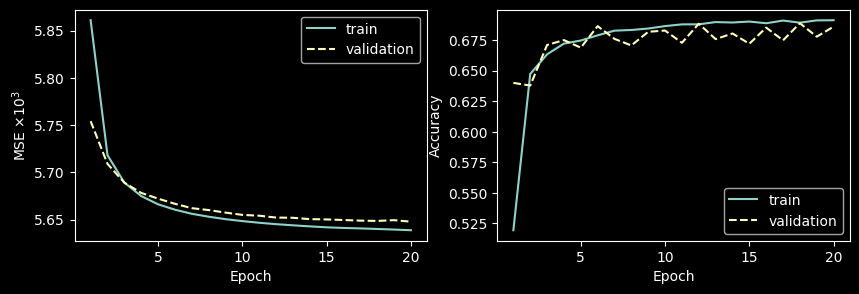

In [93]:

fig, axs = plt.subplots(1, 2, figsize=(10, 3))

axs[0].plot(range(1, n_epochs + 1), np.array(train_epochs_losses) * 1e3, label='train')
axs[0].plot(range(1, n_epochs + 1), np.array(val_epochs_losses) * 1e3, linestyle='dashed', label='validation')

axs[1].plot(range(1, n_epochs + 1), train_epochs_acc, label='train')
axs[1].plot(range(1, n_epochs + 1), val_epochs_acc, linestyle='dashed', label='validation')

axs[0].set_ylabel(loss_func_name + r' $\times 10^3$')
axs[0].set_xlabel('Epoch')
axs[0].legend()

axs[1].set_ylabel('Accuracy')
axs[1].set_xlabel('Epoch')
axs[1].legend()

plt.show()

####  Обученные маски (энкодер)


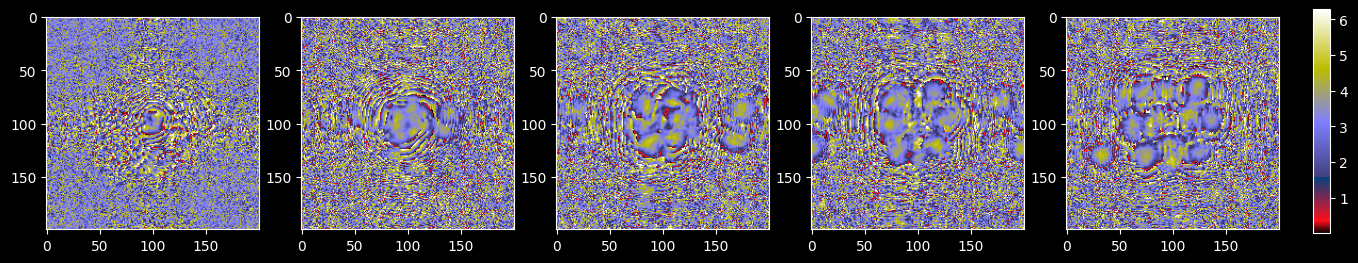

In [ ]:
n_cols = NUM_LAYERS
n_rows = 1

# plot wavefronts phase
fig, axs = plt.subplots(n_rows, n_cols, figsize=(n_cols * 3 + 2, n_rows * 3.2))
ind_diff_layer = 0

cmap = 'gist_stern'  # 'gist_stern' 'rainbow'

net_to_plot = net_to_train.net

for ind_layer, layer in enumerate(net_to_plot):
    if isinstance(layer, elements.DiffractiveLayer) or isinstance(layer, elements.SpatialLightModulator):
        # plot masks for Diffractive layers
        if n_rows > 1:
            ax_this = axs[ind_diff_layer // n_cols][ind_diff_layer % n_cols]
        else:
            ax_this = axs[ind_diff_layer % n_cols]

        # ax_this.set_title(titles[ind_module])

        trained_mask = layer.mask.detach()

        phase_mask_this = ax_this.imshow(
            trained_mask, cmap=cmap,
            # vmin=0, vmax=MAX_PHASE
        )
        ind_diff_layer += 1

        if APERTURES:
            x_frame = (x_layer_nodes - DETECTOR_SIZE[1]) / 2
            y_frame = (y_layer_nodes - DETECTOR_SIZE[0]) / 2
            ax_this.axis([x_frame, x_layer_nodes - x_frame, y_layer_nodes - y_frame, y_frame])

fig.subplots_adjust(right=0.85)
cbar_ax = fig.add_axes([0.87, 0.15, 0.01, 0.7])
plt.colorbar(phase_mask_this, cax=cbar_ax)

plt.show()

#### Сохранение результатов

In [78]:
# массив со всеми значениями потерь
all_lasses_header = ','.join([
    f'{loss_func_name.split()[0]}_train', f'{loss_func_name.split()[0]}_val',
    'accuracy_train', 'accuracy_val'
])
all_losses_array = np.array(
    [train_epochs_losses, val_epochs_losses, train_epochs_acc, val_epochs_acc]
).T


In [79]:

model_filepath = f'{RESULTS_FOLDER}/conv_net.pth'

losses_filepath = f'{RESULTS_FOLDER}/training_curves.csv'

#### Сохранение весов модели и кривых обучения

In [80]:

torch.save(net_to_train.state_dict(), model_filepath)

In [81]:

np.savetxt(
    losses_filepath, all_losses_array,
    delimiter=',', header=all_lasses_header, comments=""
)

### 4.4.1. Выберите образец для кодирования/декодирования

In [108]:
n_test_examples = 5

random.seed(78)
test_examples_ids = random.sample(range(len(mnist_wf_test_ds)), n_test_examples)

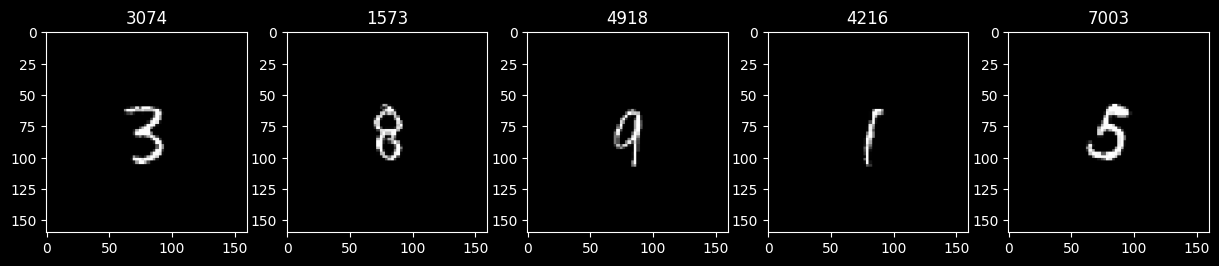

In [109]:
fig, axs = plt.subplots(1, n_test_examples, figsize=(n_test_examples * 3, 3))
cmap = 'grey'

for ax, ind_test in zip(axs, test_examples_ids):
    test_wavefront, test_target = mnist_wf_test_ds[ind_test]

    ax.set_title(f'{ind_test}')
    ax.imshow(test_wavefront.intensity, cmap=cmap)

    # ax.set_xticks([])
    # ax.set_yticks([])

plt.show()

### 4.4.2. Примеры кодирования/декодирования


#### Функция для кодирования и декодирования


In [ ]:
def encode_and_decode(autoencoder, input_wf, use_encoder_aperture=False):
    # если use_encoder_aperture = True — применяем строго квадратную апертуру к закодированному изображению
    # апертура задаётся как REGION_MASK, который использовался в функции потерь!

    with torch.no_grad():
        # КОДИРОВАНИЕ
        encoded_image = autoencoder.encode(input_wf)
        if not PRESERVE_PHASE:
            encoded_image = encoded_image.abs() + 0j  # обнуляем фазу перед декодированием!
        if use_encoder_aperture:
            encoded_image = encoded_image * REGION_MASK  # применяем апертуру к закодированному изображению

        # ДЕКОДИРОВАНИЕ
        decoded_image = autoencoder.decode(encoded_image)
        if not PRESERVE_PHASE:
            decoded_image = decoded_image.abs() + 0j  # обнуляем фазу перед декодированием!

    return encoded_image, decoded_image


#### Отображение примеров

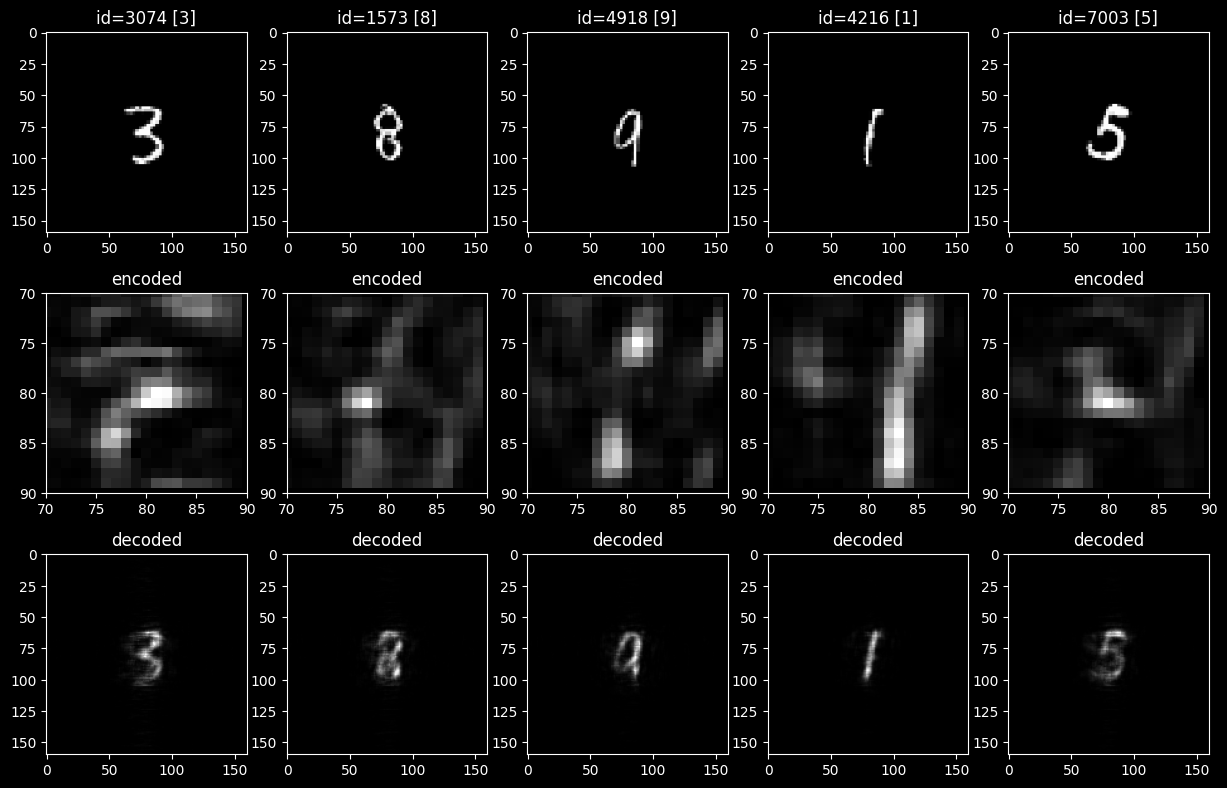

In [ ]:
n_lines = 3  # изображение / закодированное / декодированное

fig, axs = plt.subplots(n_lines, n_test_examples, figsize=(n_test_examples * 3, n_lines * 3.2))

to_plot = 'amp'  # <--- выберите, что отображать: амплитуду или фазу
cmap = 'grey'  # цветовая карта
use_encoder_aperture = True  # использовать ли апертуру после энкодера

max_amp = 1  # верхняя граница цветовой шкалы для амплитуды
max_phase = 2 * torch.pi  # верхняя граница цветовой шкалы для фазы

for ind_ex, ind_test in enumerate(test_examples_ids):
    ax_image, ax_encoded, ax_decoded = axs[0][ind_ex], axs[1][ind_ex], axs[2][ind_ex]

    test_wavefront, test_target = mnist_wf_test_ds[ind_test]

    ax_image.set_title(f'id={ind_test} [{test_target}]')
    if to_plot == 'amp':
        ax_image.imshow(
            test_wavefront.intensity, cmap=cmap,
            # vmin=0, vmax=max_amp
        )
    if to_plot == 'phase':
        ax_image.imshow(
            test_wavefront.phase, cmap=cmap,
            # vmin=0, vmax=max_phase
        )

    encoded_this, decoded_this = encode_and_decode(
        autoencoder_to_train, test_wavefront, use_encoder_aperture
    )

    ax_encoded.set_title('encoded')
    if to_plot == 'amp':
        ax_encoded.imshow(
            encoded_this.intensity, cmap=cmap,
            # vmin=0, vmax=max_amp
        )
    if to_plot == 'phase':
        ax_encoded.imshow(
            encoded_this.phase, cmap=cmap,
            # vmin=0, vmax=max_phase
        )
    if use_encoder_aperture:  # отображать только часть, проходящую через апертуру
        x_frame = (x_layer_nodes - REGION_MASK_SIZE[1]) / 2
        y_frame = (y_layer_nodes - REGION_MASK_SIZE[0]) / 2
        ax_encoded.set_xlim([x_frame, x_layer_nodes - x_frame])
        ax_encoded.set_ylim([y_layer_nodes - y_frame, y_frame])

    ax_decoded.set_title('decoded')
    if to_plot == 'amp':
        ax_decoded.imshow(
            decoded_this.intensity, cmap=cmap,
            # vmin=0, vmax=max_amp
        )
    if to_plot == 'phase':
        ax_decoded.imshow(
            decoded_this.phase, cmap=cmap,
            # vmin=0, vmax=max_phase
        )

plt.show()
